Social Dimensions of Eaton and Palisades fires
poverty, disability, mobile homes

In [ ]:
import os
import geopandas as gpd
import rioxarray as rioxr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import contextily as ctx

In [2]:
# Import data
fp = os.path.join('data', 'California_Historic_Fire_Perimeters', 'California_Fire_Perimeters_(1950+).shp')
fires = gpd.read_file(fp)

fp= os.path.join('data', 'EJI_2024_United_States', 'EJI_2024_United_States.gdb')
eji = gpd.read_file(fp)

In [3]:
# Check crs of each data
print(fires.crs)
print(fires.crs.is_projected)

print(eji.crs)
print(eji.crs.is_projected)

EPSG:3857
True
PROJCS["USA_Contiguous_Albers_Equal_Area_Conic",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",37.5],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["ESRI","102003"]]
True


In [4]:
fires.head()

,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,C_METHOD,OBJECTIVE,GIS_ACRES,COMMENTS,COMPLEX_NA,IRWINID,FIRE_NUM,COMPLEX_ID,DECADES,geometry
0,2025,CA,CDF,LDF,PALISADES,00000738,2025-01-07,2025-01-31,14,7,1,23448.900,None,None,{A7EA5D21-F882-44B8-BF64-44AB11059DC1},None,None,2020-January 2025,"MULTIPOLYGON (((-13193558.265 4032826.468, -13..."
1,2025,CA,CDF,LAC,EATON,00009087,2025-01-08,2025-01-31,14,7,1,14056.300,None,None,{72660ADC-B5EF-4D96-A33F-B4EA3740A4E3},None,None,2020-January 2025,"MULTIPOLYGON (((-13146936.686 4051222.067, -13..."
2,2025,CA,CDF,ANF,HUGHES,00250270,2025-01-22,2025-01-28,14,7,1,10396.800,None,None,{994072D2-E154-434A-BB95-6F6C94C40829},None,None,2020-January 2025,"MULTIPOLYGON (((-13197885.239 4107084.744, -13..."
3,2025,CA,CCO,VNC,KENNETH,00003155,2025-01-09,2025-02-04,14,2,1,998.738,from OES Intel 24,None,{842FB37B-7AC8-4700-BB9C-028BF753D149},None,None,2020-January 2025,"POLYGON ((-13211054.577 4051508.758, -13211051..."
4,2025,CA,CDF,LDF,HURST,00003294,2025-01-07,2025-01-09,14,7,1,831.385,None,None,{F4E810AD-CDF3-4ED4-B63F-03D43785BA7B},None,None,2020-January 2025,"POLYGON ((-13187991.688 4073306.403, -13187979..."


## Spatially join data
- change the crs to match
- filter fires to only palisades and eaton

In [5]:
fires.columns

Index(['YEAR_', 'STATE', 'AGENCY', 'UNIT_ID', 'FIRE_NAME', 'INC_NUM',
       'ALARM_DATE', 'CONT_DATE', 'CAUSE', 'C_METHOD', 'OBJECTIVE',
       'GIS_ACRES', 'COMMENTS', 'COMPLEX_NA', 'IRWINID', 'FIRE_NUM',
       'COMPLEX_ID', 'DECADES', 'geometry'],
      dtype='object')

In [6]:
fires.columns = fires.columns.str.lower()


In [7]:
fires.fire_name.unique()

array(['PALISADES', 'EATON', 'HUGHES', ..., 'PEREZ', 'GOAT MTN',
       'MCCOULTER'], dtype=object)

In [8]:
palisade = fires[(fires['fire_name'] == 'PALISADES') & (fires['year_'] == 2025)]
eaton = fires[(fires['fire_name'] == 'EATON') & (fires['year_'] == 2025)]

In [ ]:
eji = eji.to_crs(crs = 'epsg:3857')
# or use fires.crs

In [10]:
eji.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [21]:
# Spatial join
palisade_soc = gpd.sjoin(left_df = eji, 
                        right_df = palisade,
how = 'inner')

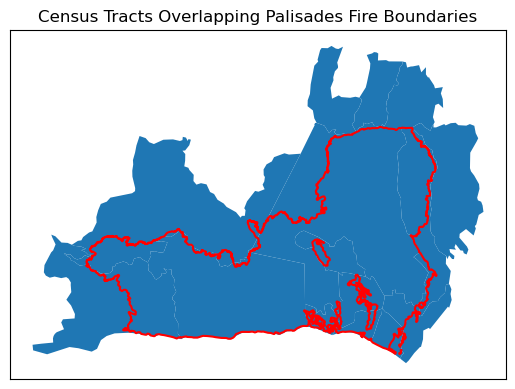

In [23]:
fig, ax = plt.subplots()
palisade_soc.plot(ax=ax)
palisade.boundary.plot(ax=ax, edgecolor = "red")
plt.title("Census Tracts Overlapping Palisades Fire Boundaries")
# Remove axes ticks
ax.set_xticks([])  
ax.set_yticks([])   

plt.show()

In [14]:
# Create geodf for the Eaton fire
# Spatial join
eaton_soc = gpd.sjoin(eji, eaton,
how = 'inner')

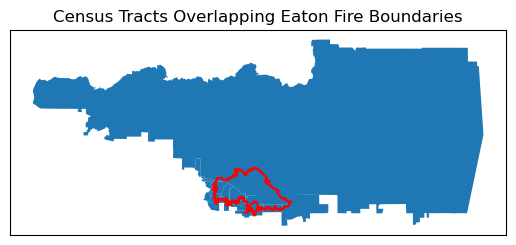

In [15]:
fig, ax = plt.subplots()
eaton_soc.plot(ax=ax)
eaton.boundary.plot(ax=ax, edgecolor = "red")
plt.title("Census Tracts Overlapping Eaton Fire Boundaries")
# Remove axes ticks
ax.set_xticks([])  
ax.set_yticks([])  

# Remove axes labels
ax.set_xlabel("")  
ax.set_ylabel("")  

plt.show()

In [20]:
# Clip the census tracts overlapping palisades to the boundary of the fire
palisade_clip = gpd.clip(eji, palisade)

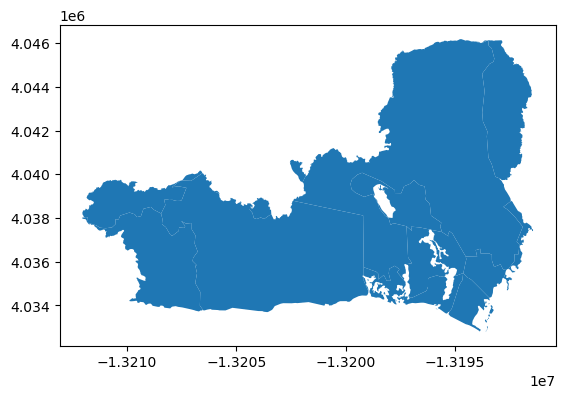

In [25]:
fig, ax = plt.subplots()
palisade_clip.plot(ax=ax)
plt.show()

In [24]:
eaton_clip = gpd.clip(eji, eaton)

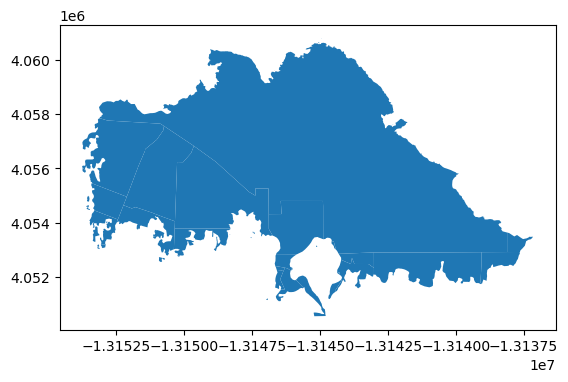

In [26]:
fig, ax = plt.subplots()
eaton_clip.plot(ax=ax)
plt.show()

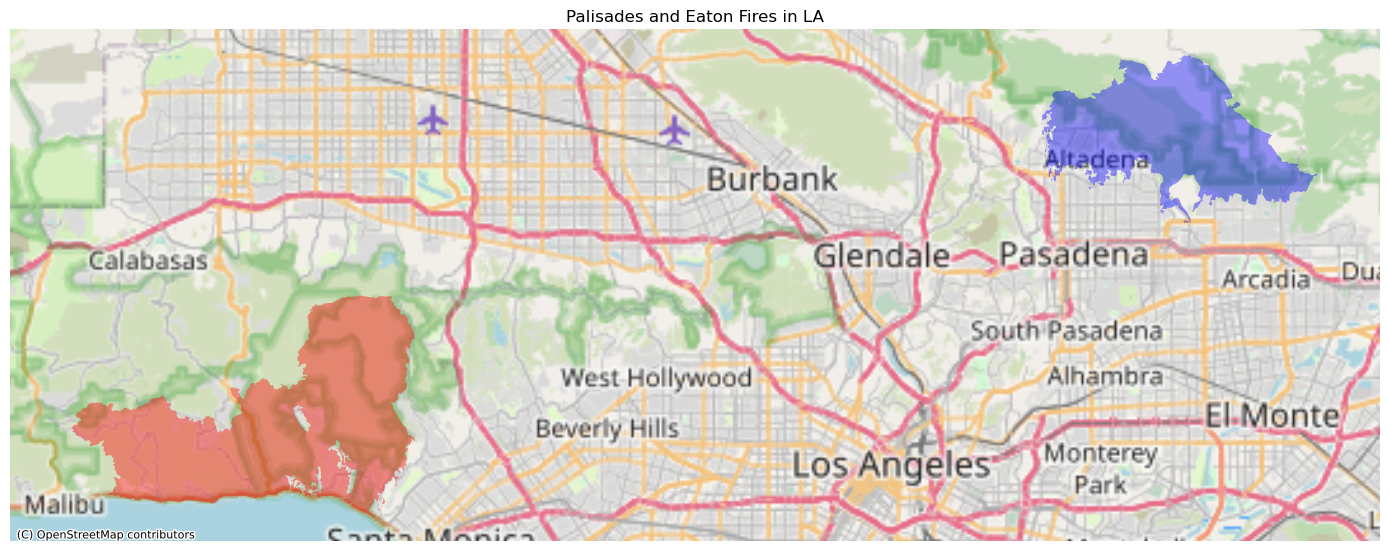

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(14, 12))

palisade.plot(ax=ax, color = "red", alpha = 0.4)

eaton.plot(ax=ax, color = "blue", alpha = 0.4)
# Add basemap using contextily
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs = palisade.crs)

ax.set_title("Palisades and Eaton Fires in LA")

ax.axis('off')

plt.tight_layout()
plt.show()

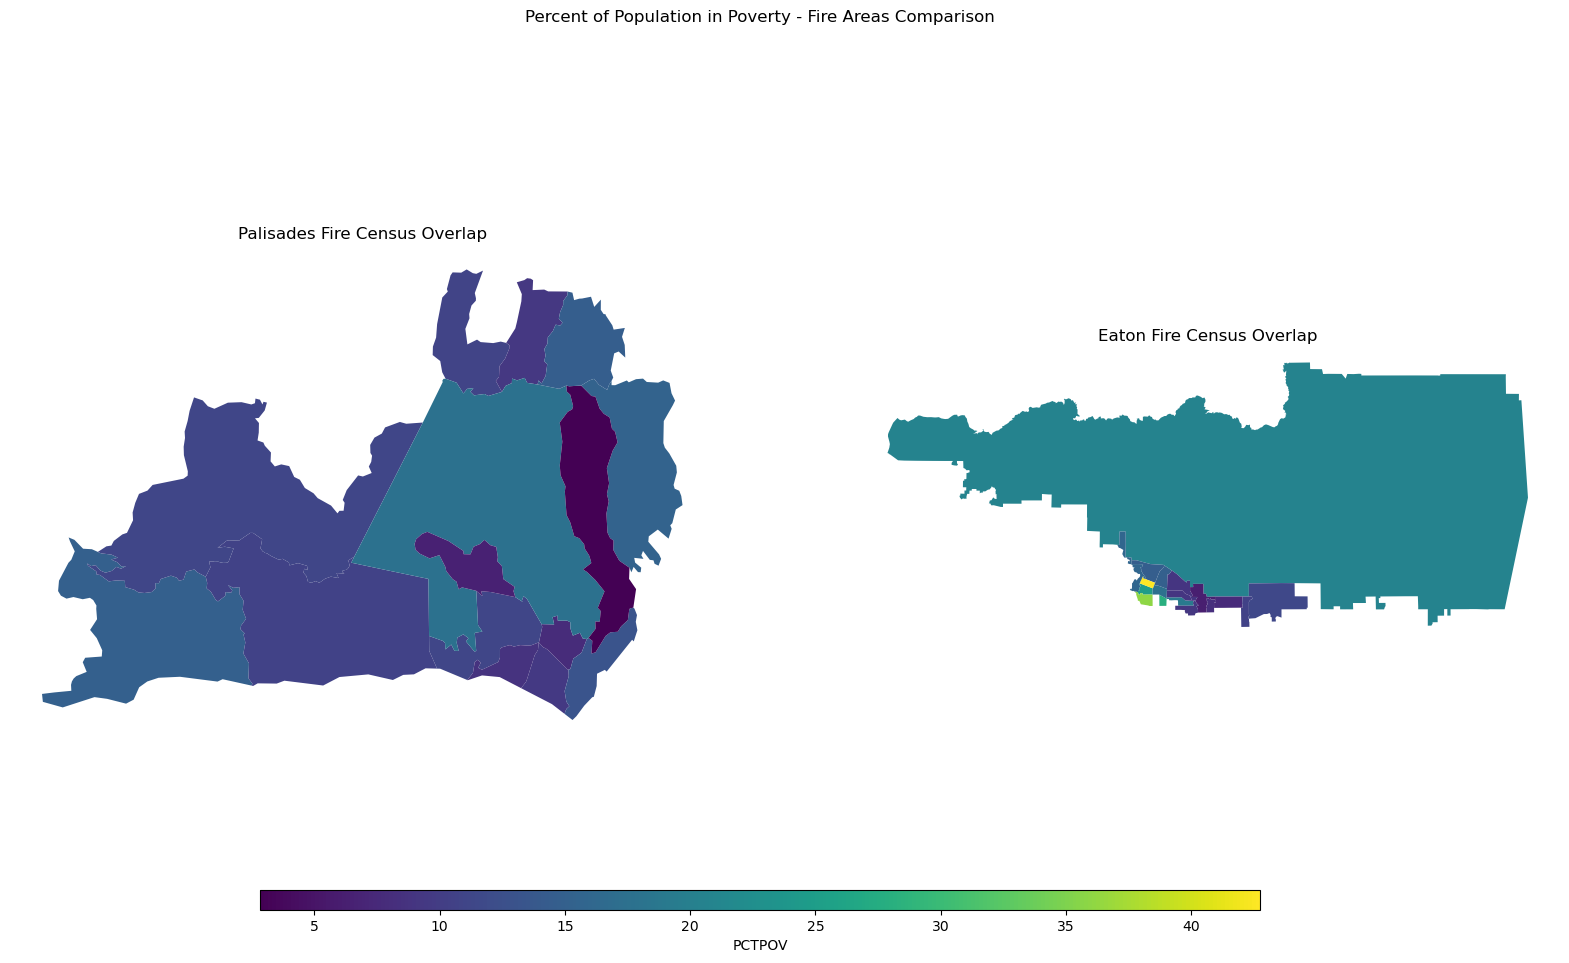

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# UPDATE WITH YOU EJI VARIABLE FROM STEP 1
eji_variable = 'E_POV200'

# Find common min/max for legend range
vmin = min(palisade_soc[eji_variable].min(), eaton_soc[eji_variable].min())
vmax = max(palisade_soc[eji_variable].max(), eaton_soc[eji_variable].max())

# Plot census tracts within Palisades perimeter
palisade_soc.plot(
    column= eji_variable,
    vmin=vmin, vmax=vmax,
    legend=False,
    ax=ax1,
)
ax1.set_title('Palisades Fire Census Overlap')
ax1.axis('off')

# Plot census tracts within Eaton perimeter
eaton_soc.plot(
    column=eji_variable,
    vmin=vmin, vmax=vmax,
    legend=False,
    ax=ax2,
)
ax2.set_title('Eaton Fire Census Overlap')
ax2.axis('off')

# Add overall title
fig.suptitle('Percent of Population in Poverty - Fire Areas Comparison')

# Add shared colorbar at the bottom
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('PCTPOV')

plt.show()